In [2]:
from nile.api.v1 import (
    clusters,
    aggregators as na,
    filters as nf,
    extractors as ne,
    Record
)

import json
from qb2.api.v1 import filters as sf, extractors as se

import datetime
import pandas as pd
import re

In [3]:
cluster = clusters.Hahn().env(
    templates=dict(
        # date='{2017-01-16..2017-01-22}'
        date='{2017-12-18..2017-12-18}'
    )
)

In [4]:
def extract(records):
    for record in records:
        if record.type != '2':
            continue
        url = record.url
        try:
            parsed = json.loads(record.data)
        except:
            continue
            
        if parsed is None:
            continue 
            
        for event in parsed:
            if (event is not None) and ('type' in event) and (event['type'] == 'event'):
#                 yield Record(event = event, url = url)
                try:
                    data_parsed = json.loads(event['data'])
                except:
                    data_parsed = {}
                
                event_type = ''
                if (data_parsed is not None) and ('type' in data_parsed):
                    event_type = data_parsed['type']
                    
                stamp = ''
                if (data_parsed is not None) and ('stamp' in data_parsed):
                    stamp = data_parsed['stamp']
                    
                    
                input_value = ''
                try:
                    input_value = data_parsed['meta']['value']
                except:
                    pass
                
                if event_type in ('change', 'input'):
                    yield Record(
                        event = event, 
                        data_parsed = data_parsed, 
                        event_type = event_type,
                        input_value = input_value,
                        url = record.url,
                        uniqid = record.uniqid,
                        counterid = record.counterid,
                        hit = record.hit,
                        requestid = record.requestid,
                        part = record.part,
                        unixtime = record.unixtime,
                        stamp = stamp
                    )
                    

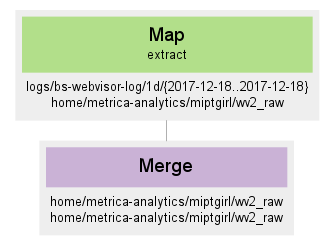

In [5]:
job = cluster.job()

log =  job.table('logs/bs-webvisor-log/1d/@date').map(extract)\
    .put('home/metrica-analytics/miptgirl/wv2_raw')
    
job.commands_graph

In [ ]:
job.run()

In [133]:
## credit cards

In [174]:
import re

def is_valid_cc(inp):
    inp = str(inp)
    
    skipped_symbols = ['\t', '\n', ' ']
    
    for symbol in skipped_symbols:
        inp = inp.replace(symbol, '')
        
    if re.match('^[0-9]{12,19}$', inp) is None:
        return False
        
    if len(inp) % 2 == 0:
        doubled_indexes = range(0, len(inp), 2)
    else:
        doubled_indexes = range(1, len(inp), 2)
        
    fin_sum = 0
    for index in range(len(inp)):
        if index in doubled_indexes:
            val = int(inp[index])*2
            if val > 9:
                val = val - 9
        else:
            val = int(inp[index])

        fin_sum += val
    
    first2 = int(inp[:2])
    first4 = int(inp[:4])
    
    if len(inp) != 16:
        return False
    
    # Maestro
    if (inp[0] == '6') or (first2 in (50, 56, 57, 58)):
        return True
    
    # Master Card
    if (len(inp) == 16) and (
        ((first2 >= 51) and (first2 <= 55))
        or
        ((first4 >= 2221) and (first4 <= 2720))
    ):
        return True
    
    # Visa
    if (len(inp) in (13, 16, 19)) and (inp[0] == '4'):
        return True
    
    
    # MIR
    if (len(inp) == 16) and (first2 >= 2200) and (first2 <= 2204):
        return True
    
    return False

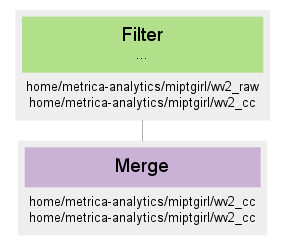

In [175]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_raw')\
    .filter(nf.custom(is_valid_cc, 'input_value'))\
    .put('home/metrica-analytics/miptgirl/wv2_cc')
    
job.commands_graph

In [176]:
job.run()

In [168]:
import urlparse

def get_domain(url):
    return urlparse.urlparse(url).netloc.replace('www.', '')

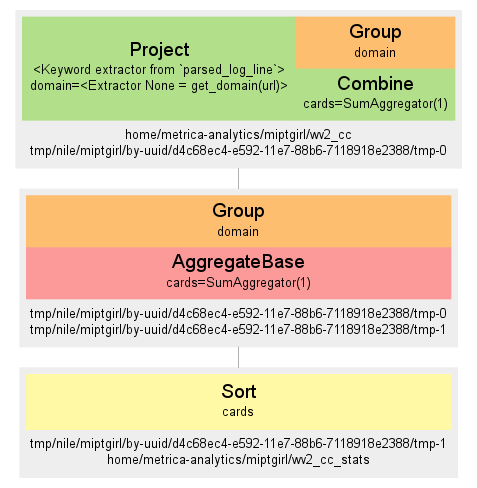

In [169]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_cc')\
    .project(ne.all(), domain = ne.custom(get_domain, 'url'))\
    .groupby('domain').aggregate(cards = na.count())\
    .sort('cards')\
    .put('home/metrica-analytics/miptgirl/wv2_cc_stats')
    
job.commands_graph

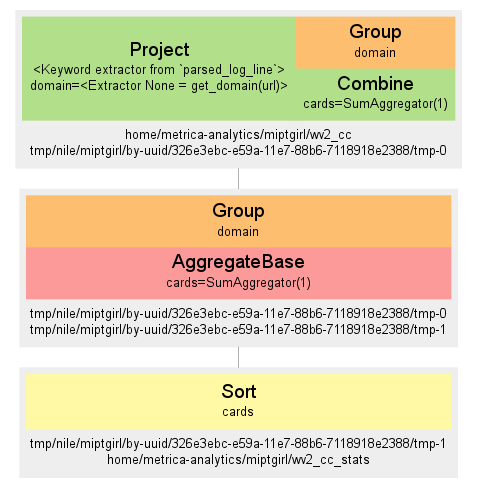

In [182]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_cc')\
    .project(ne.all(), domain = ne.custom(get_domain, 'url'))\
    .groupby("domain").aggregate(cards = na.count())\
    .sort('cards')\
    .put('home/metrica-analytics/miptgirl/wv2_cc_stats')
    
job.commands_graph

In [183]:
job.run()

In [184]:
cc_sites_df = cluster.read('home/metrica-analytics/miptgirl/wv2_cc_stats').as_dataframe()

In [201]:
def df_to_wiki(df, show_index = False):
    return '#|\n ||' + df.to_csv(index = show_index, sep = '|').replace('|', ' | ').replace('\n', '|| \n ||')[:-2] + '|#'

df_to_wiki(cc_sites_df.sort_values('cards', ascending = False).head(10))

'#|\n ||cards | domain|| \n ||2612 | money.yandex.ru|| \n ||2528 | paysend.com|| \n ||1485 | tsum.ru|| \n ||1300 | kassa.cc|| \n ||1111 | stelsvelo.ru|| \n ||1003 | online.atlasglb.com|| \n ||509 | letyshops.com|| \n ||381 | m.atlasglb.com|| \n ||166 | auto.ru|| \n ||130 | flowwow.com|| \n |#'

In [186]:
cc_sites_df.sort_values('cards', ascending = False).head(10)

,cards,domain
196,2612,money.yandex.ru
195,2528,paysend.com
194,1485,tsum.ru
193,1300,kassa.cc
192,1111,stelsvelo.ru
191,1003,online.atlasglb.com
190,509,letyshops.com
189,381,m.atlasglb.com
188,166,auto.ru
187,130,flowwow.com


In [10]:
### user activities

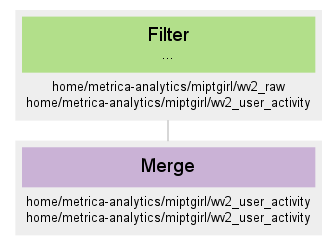

In [12]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_raw')\
    .filter(
        nf.custom(lambda x, y: (str(x) == '36660770') and (str(y) == '9312130341512458719'), 
                  'counterid', 'uniqid')
    )\
    .put('home/metrica-analytics/miptgirl/wv2_user_activity')
    
job.commands_graph

In [13]:
job.run()

In [19]:
user_df = cluster.read('tmp/miptgirl/cf6a6f56-6fc7edf4-352d695a-c').as_dataframe()

In [24]:
user_df_filt = user_df[user_df.type == '2'][[
       u'browserinfo', u'counterclass', u'counterid', u'data',
       u'eventtime', u'hit', u'iso_eventtime', u'part',
       u'requestid', u'source_uri', u'timestamp',
       u'type', u'uniqid', u'unixtime', u'url']]

In [27]:
user_df_filt['data_parsed'] = map(lambda x: json.loads(x), user_df_filt.data)

In [119]:
request_data = user_df_filt[user_df_filt.requestid == '000560A0BEEBFB80000007272510FD43'].iloc[0].data_parsed

In [120]:
request_df = pd.DataFrame(request_data)

In [121]:
request_df['data_parsed'] = map(lambda x: json.loads(x), request_df.data)

In [122]:
request_df['event_type'] = map(lambda x: x['type'] if 'type' in x else '', request_df.data_parsed)
request_df['event_stamp'] = map(lambda x: x['stamp'] if 'stamp' in x else 0, request_df.data_parsed)
#request_df['input_value'] = map(lambda x: x['meta']['value'] if (x is not None) and ('meta' in x) and ('value' in x['meta']) else '', request_df.data_parsed)

In [128]:
def get_input_value(x):
    try:
        return x['meta']['value']
    except:
        return ''
    
request_df['input_value'] = map(get_input_value, request_df.data_parsed)

In [136]:
request_df[request_df.input_value == '2033708850186797'].iloc[0].data_parsed

{u'meta': {u'checked': False, u'value': u'2033708850186797'},
 u'stamp': 0,
 u'target': 2757,
 u'type': u'change'}

In [155]:
values = []

for request_event in request_df[request_df.type == 'mutation'].to_dict('records'):
    print 'hello'
    for changes in request_event['data_parsed']['meta']['changes']:
        for k in changes:
            for change in changes[k]:
                if change['id'] == 2757:
                    values.append(change)

In [156]:
values

[{u'at': {u'name': u'id'}, u'id': 2757, u'nm': u'INPUT', u'pa': 2755}]

In [157]:
values = []

for request_event in request_df[request_df.type == 'mutation'].to_dict('records'):
    print 'hello'
    for changes in request_event['data_parsed']['meta']['changes']:
        for k in changes:
            for change in changes[k]:
                if change['id'] == 2755:
                    values.append(change)

In [158]:
values

[{u'at': {u'accept-charset': u'utf-8',
   u'action': u'https://www.facebook.com/tr/',
   u'method': u'post',
   u'style': u'display: none;',
   u'target': u'fb07386214387166712'},
  u'id': 2755,
  u'nm': u'FORM',
  u'pa': 144,
  u'pr': 2737},
 {u'id': 2755, u'pa': 144, u'pr': 2737}]

In [161]:
for item in initial_state:
    if item['id'] == 144:
        break
        
item

{u'attributes': {u'class': u'cbp-spmenu-push'},
 u'id': 144,
 u'name': u'body',
 u'parent': 0}

In [193]:
### emails

def is_email(inp):
    inp = str(inp)
    inp = inp.strip()
    return  re.match('^([a-z0-9_\.-]+)@([a-z0-9_\.-]+)\.([a-z\.]{2,6})$', inp) is not None

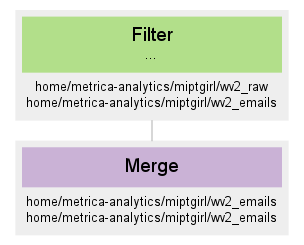

In [194]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_raw')\
    .filter(nf.custom(is_email, 'input_value'))\
    .put('home/metrica-analytics/miptgirl/wv2_emails')
    
job.commands_graph

In [195]:
job.run()

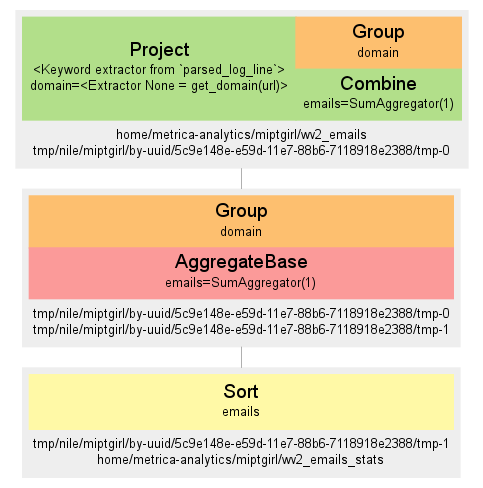

In [196]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_emails')\
    .project(ne.all(), domain = ne.custom(get_domain, 'url'))\
    .groupby("domain").aggregate(emails = na.count())\
    .sort('emails')\
    .put('home/metrica-analytics/miptgirl/wv2_emails_stats')
    
job.commands_graph

In [197]:
job.run()

In [198]:
emails_sites_df = cluster.read('home/metrica-analytics/miptgirl/wv2_emails_stats').as_dataframe()

In [202]:
df_to_wiki(emails_sites_df.sort_values('emails', ascending = False).head(20))

'#|\n ||domain | emails|| \n ||bypass.org.ru | 92998|| \n ||realty.yandex.ru | 68684|| \n ||ulmart.ru | 62965|| \n ||femida.yandex-team.ru | 50879|| \n ||alfastrah.ru | 45013|| \n ||cian.ru | 38740|| \n ||kontur.ru | 31589|| \n ||direct.yandex.ru | 30414|| \n ||eli.ru | 30302|| \n ||tsum.ru | 21270|| \n ||serpstat.com | 17966|| \n ||m.realty.yandex.ru | 17048|| \n ||krasniykarandash.ru | 13509|| \n ||letyshops.com | 12214|| \n ||lk.direct-credit.ru | 10624|| \n ||web-zaim.ru | 9923|| \n ||narcofree.ru | 8533|| \n ||mobil.dominos.com.tr | 8429|| \n ||geekbrains.ru | 8260|| \n ||epayments.com | 8193|| \n |#'

In [203]:
##mobile phones

In [233]:
def is_mobile_phone(inp):
    inp = str(inp)
    inp = inp.strip()
    pattern = '^((8|\+?7)[\- ]?)?(\(?\d{3}\)?[\- ]?)?[\d\- ]{7,10}$'
    
    if re.match(pattern, inp) is None:
        return False
    
    nums = ''.join(filter(lambda x: x.isalnum(), list(inp)))
    
    if len(nums) != 11:
        return False
     
    code = int(nums[1:4])
    codes = [900, 901, 902, 903, 904, 905, 906, 908, 909, 910, 911, 912, 913, 
             914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 
             927, 928, 929, 930, 931, 932, 933, 934, 936, 937, 938, 939, 941, 
             950, 951, 952, 953, 954, 955, 956, 958, 960, 961, 962, 963, 964, 
             965, 966, 967, 968, 969, 970, 971, 977, 978, 980, 981, 982, 983, 
             984, 985, 986, 987, 988, 989, 991, 992, 993, 994, 995, 996, 997, 999]
    
    return code in codes

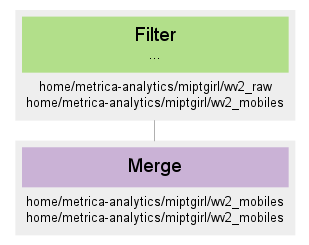

In [234]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_raw')\
    .filter(nf.custom(is_mobile_phone, 'input_value'))\
    .put('home/metrica-analytics/miptgirl/wv2_mobiles')
    
job.commands_graph

In [235]:
job.run()

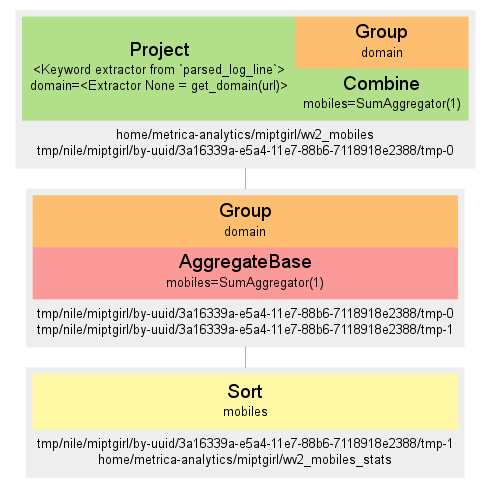

In [236]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_mobiles')\
    .project(ne.all(), domain = ne.custom(get_domain, 'url'))\
    .groupby("domain").aggregate(mobiles = na.count())\
    .sort('mobiles')\
    .put('home/metrica-analytics/miptgirl/wv2_mobiles_stats')
    
job.commands_graph

In [237]:
job.run()

In [238]:
mobiles_sites_df = cluster.read('home/metrica-analytics/miptgirl/wv2_mobiles_stats').as_dataframe()

In [241]:
df_to_wiki(mobiles_sites_df.sort_values('mobiles', ascending = False).head(20))

'#|\n ||domain | mobiles|| \n ||ulmart.ru | 50488|| \n ||alfastrah.ru | 35119|| \n ||stolicasveta.ru | 12303|| \n ||geekbrains.ru | 12028|| \n ||eli.ru | 8512|| \n ||apex.ru | 6009|| \n ||tsum.ru | 4743|| \n ||sovest.ru | 4644|| \n ||fotooboi-s-dostavkoy.ru | 3707|| \n ||web-zaim.ru | 3470|| \n ||letyshops.com | 3326|| \n ||dozarplati.com | 3281|| \n ||funburg.ru | 2947|| \n ||sales.ubrr.ru | 2895|| \n ||stock.ulmart.ru | 2708|| \n ||app.mtsbank.ru | 2287|| \n ||money.yandex.ru | 2221|| \n ||bypass.org.ru | 2164|| \n ||shiptor.ru | 2069|| \n ||lk.direct-credit.ru | 1984|| \n |#'

### дата рождения

In [242]:
from dateutil.parser import parse

In [256]:
def is_birthday(inp):
    inp = str(inp).strip()
    if re.match(r'[0-9]{2,4}([./-])[0-9]{2,2}([./-])[0-9]{2,4}', inp) is None:
        return False
    
    date = None
    
    try:
        date = parse(inp)
        delta = (datetime.datetime.today() - date).days 
        if (delta >= 365*10) and (delta <= 365*150):
            return True
        else:
            return False
    except:
        return False

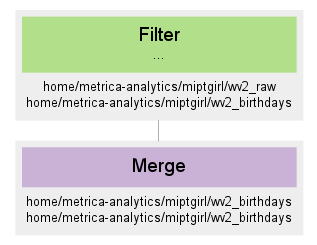

In [257]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_raw')\
    .filter(nf.custom(is_birthday, 'input_value'))\
    .put('home/metrica-analytics/miptgirl/wv2_birthdays')
    
job.commands_graph

In [258]:
job.run()

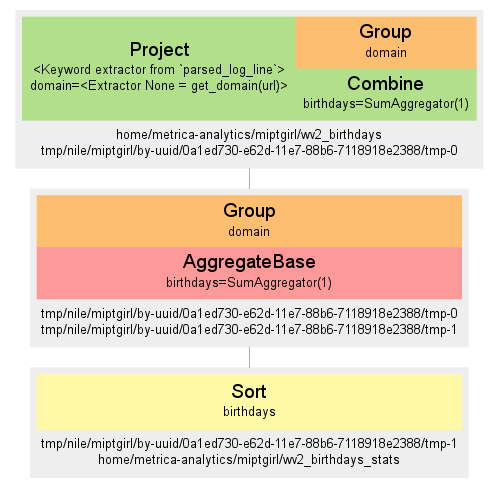

In [259]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_birthdays')\
    .project(ne.all(), domain = ne.custom(get_domain, 'url'))\
    .groupby("domain").aggregate(birthdays = na.count())\
    .sort('birthdays')\
    .put('home/metrica-analytics/miptgirl/wv2_birthdays_stats')
    
job.commands_graph

In [260]:
job.run()

In [261]:
birthdays_sites_df = cluster.read('home/metrica-analytics/miptgirl/wv2_birthdays_stats').as_dataframe()

In [263]:
df_to_wiki(birthdays_sites_df.sort_values('birthdays', ascending = False).head(20))

'#|\n ||birthdays | domain|| \n ||149528 | alfastrah.ru|| \n ||36567 | amwine.ru|| \n ||22380 | lk.direct-credit.ru|| \n ||5743 | online.atlasglb.com|| \n ||5379 | strahovkaru.ru|| \n ||3168 | app.mtsbank.ru|| \n ||2828 | sales.ubrr.ru|| \n ||1881 | denga.ru|| \n ||1560 | ulmart.ru|| \n ||1213 | web-zaim.ru|| \n ||1107 | yandex.ru|| \n ||791 | dozarplati.com|| \n ||667 | 88005500600.ru|| \n ||559 | promo-belmarket.by|| \n ||513 | money.yandex.ru|| \n ||451 | m.credit-history24.ru|| \n ||441 | retailstars.ru|| \n ||420 | tsum.ru|| \n ||396 | centrofinans.ru|| \n ||355 | rrg.ru|| \n |#'

## passport

In [313]:
codes = ['79', '84', '80', '81', '82', '26', '83', '85', '91', '86', '87', '88', '89', '98', '90', '92', 
         '93', '94', '95', '96', '97', '1', '3', '4', '5', '7', '8', '11', '12', '14', '15', '17', '19', 
         '20', '24', '25', '27', '29', '20', '32', '33', '34', '37', '38', '41', '42', '44', '46', '47', 
         '22', '49', '50', '52', '53', '54', '56', '57', '58', '60', '61', '36', '63', '64', '65', '66', 
         '68', '28', '69', '73', '75', '76', '78', '45', '40', '99', '43', '48', '51', '55', '59', '62', 
         '67', '77', '72', '74']

pass_codes = map(lambda x: x if len(x) == 2 else '0'+ x, codes)

def is_passport(inp):
    inp = str(inp).strip()
    if re.match('^[0-9]{4}([ /-])[0-9]{6}$', inp) is None:
        return False

    if inp[:2] in pass_codes:
        return True
    else:
        return False

In [314]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_raw')\
    .filter(nf.custom(is_passport, 'input_value'))\
    .put('home/metrica-analytics/miptgirl/wv2_passports')
    
job.run()

In [315]:
job = cluster.job()

log =  job.table('home/metrica-analytics/miptgirl/wv2_passports')\
    .project(ne.all(), domain = ne.custom(get_domain, 'url'))\
    .groupby("domain").aggregate(passports = na.count())\
    .sort('passports')\
    .put('home/metrica-analytics/miptgirl/wv2_passports_stats')
    
job.run()

In [318]:
passports_sites_df = cluster.read('home/metrica-analytics/miptgirl/wv2_passports_stats').as_dataframe()

In [319]:
df_to_wiki(passports_sites_df.sort_values('passports', ascending = False).head(20))

'#|\n ||domain | passports|| \n ||app.mtsbank.ru | 2187|| \n ||sales.ubrr.ru | 1604|| \n ||lk.direct-credit.ru | 991|| \n ||yandex.ru | 659|| \n ||m.credit-history24.ru | 376|| \n ||money.yandex.ru | 262|| \n ||postabank.ru | 199|| \n ||forma2.zaem911.ru | 184|| \n ||tariff-editor.taxi.yandex-team.ru | 119|| \n ||credit-history24.ru | 116|| \n ||smartseeds.ru | 23|| \n ||alfastrah.ru | 23|| \n ||zomart.ru | 19|| \n ||forma1.zaem911.ru | 15|| \n ||cp.hoster.ru | 15|| \n ||rasp-agent04h-trusty.haze.yandex.net | 14|| \n ||veha-corp.ru | 10|| \n ||paulcamper.de | 10|| \n ||front-main.trn1.ymdev.yandex.ru | 8|| \n ||handmademart.net | 8|| \n |#'